In [3]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mlxtend

     |████████████████████████████████| 1.3 MB 5.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [14]:
df=pd.read_csv('yelp 2.csv')

In [6]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [9]:
df.isnull().sum()

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64

In [15]:
## Let's drop irrelevant info from our table
df=df.drop(['business_id','date','review_id','type','user_id','cool','useful','funny'],axis=1)

In [16]:
df.head()

,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [18]:
## Look at length of review in comparison with the stars given
text_length=[]
for i in df['text']:
    text_length.append(len(i))

In [20]:
df['text_length']= text_length

In [21]:
df.head()

,stars,text,text_length
0,5,My wife took me here on my birthday for breakf...,889
1,5,I have no idea why some people give bad review...,1345
2,4,love the gyro plate. Rice is so good and I als...,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",419
4,5,General Manager Scott Petello is a good egg!!!...,469


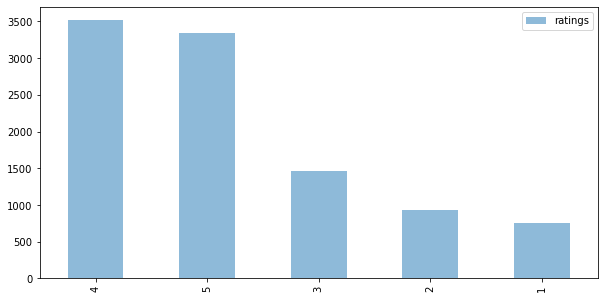

In [22]:
## Visualize this 
plt.figure(figsize=(10,5))
df['stars'].value_counts().plot(kind='bar',alpha=0.5,label='ratings')
plt.legend()
plt.show()

In [23]:
## Cleaning up the data and categorizing 1-3 stars as 0 and 4-5 as 1 
df['stars']=np.where(df['stars']>3,1,0)


In [24]:
df.head()

,stars,text,text_length
0,1,My wife took me here on my birthday for breakf...,889
1,1,I have no idea why some people give bad review...,1345
2,1,love the gyro plate. Rice is so good and I als...,76
3,1,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",419
4,1,General Manager Scott Petello is a good egg!!!...,469


In [28]:
positive=[]
negative=[]
positive_reviews=df[df['stars']==1]['text']
negative_reviews=df[df['stars']==0]['text']

In [29]:
## Tokenize the good and bad review words 
def extract_positive(positive_reviews):
    global positive
    words = [word.lower() for word in word_tokenize(positive_reviews) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    positive=positive+words

In [30]:
def extract_negative(negative_reviews):
    global negative
    words = [word.lower() for word in word_tokenize(negative_reviews) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    negative=negative+words

In [31]:
positive_reviews.apply(extract_positive)
negative_reviews.apply(extract_negative)

15      None
16      None
18      None
20      None
23      None
        ... 
9983    None
9984    None
9987    None
9995    None
9998    None
Name: text, Length: 3137, dtype: object

In [34]:

pip install WordCloud

  Using cached wordcloud-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (366 kB)
Note: you may need to restart the kernel to use updated packages.


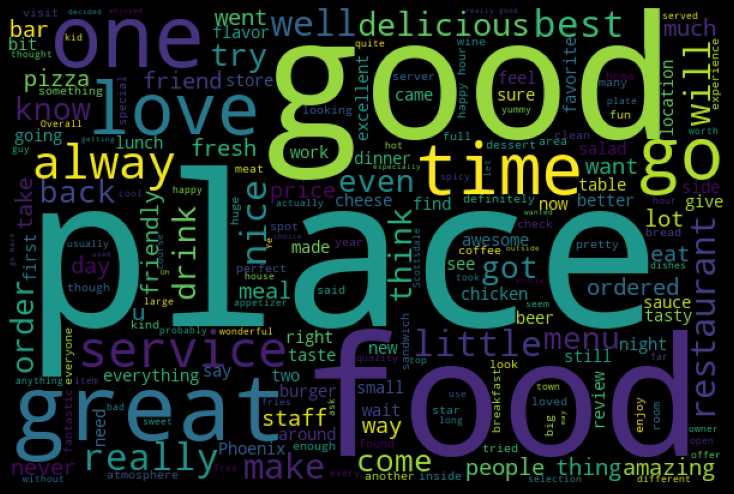

In [35]:
## look at the key words used in good reviews 
from wordcloud import WordCloud
pos_review_cloud=WordCloud(width=600,height=400).generate(" ".join(positive_reviews))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(pos_review_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

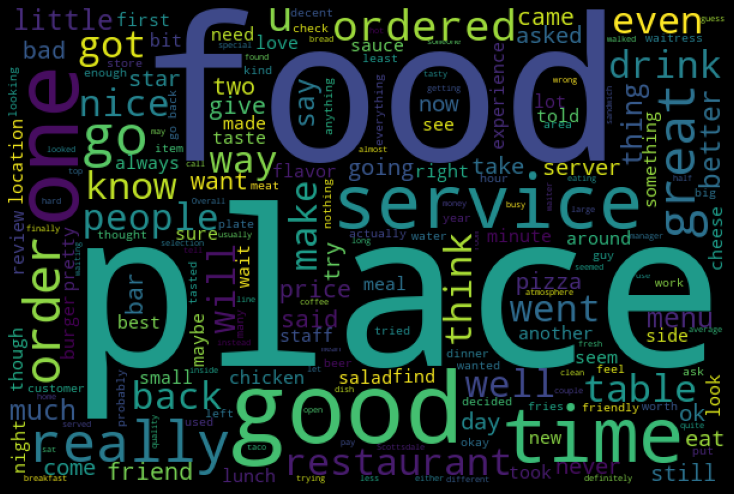

In [38]:
neg_review_cloud=WordCloud(width=600,height=400,background_color='black').generate(" ".join(negative_reviews))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(neg_review_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [39]:
stemmer = SnowballStemmer("english")

def ReadyText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

df["text"] = df["text"].apply(ReadyText)
df.head(n = 10)    

,stars,text,text_length
0,1,wife took birthday breakfast excel weather per...,889
1,1,idea peopl give bad review place goe show plea...,1345
2,1,love gyro plate rice good also dig candi select,76
3,1,rosi dakota love chaparr dog park conveni surr...,419
4,1,general manag scott petello good egg go detail...,469
5,1,quiessenc simpli put beauti full window earthi...,2094
6,1,drop your drive ate go back next day food good...,1565
7,1,luckili didnt travel far make connect flight t...,274
8,1,definit come happi hour price amaz sake bomber...,349
9,1,nobuo show uniqu talent everyth menu care craf...,186


In [40]:
## create different x and y variables 
y=df['stars']
x=df['text']

In [41]:
## create a train and test data set 
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)

In [43]:
cv=CountVectorizer()
lr=LogisticRegression(max_iter=10000)
x_train=cv.fit_transform(x_train)
lr.fit(x_train,y_train)
pred_1=lr.predict(cv.transform(x_test))
score_1=accuracy_score(y_test,pred_1)

<Figure size 432x288 with 0 Axes>

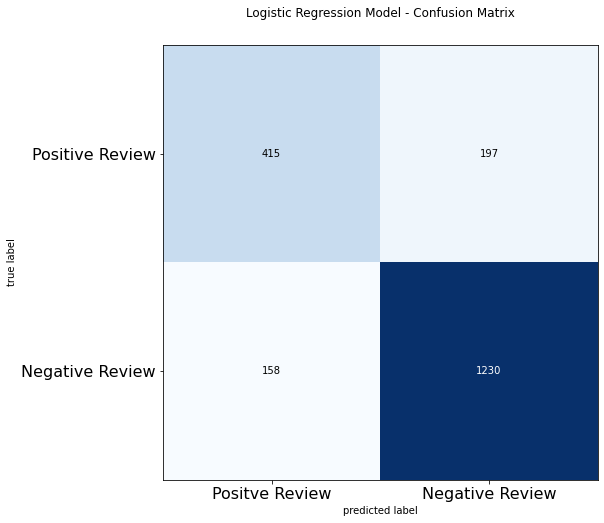

In [44]:
cm = confusion_matrix(y_test, pred_1)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Positve Review","Negative Review"], fontsize=16)
plt.yticks(range(2), ["Positive Review","Negative Review"], fontsize=16)
plt.show()

In [47]:
nb=MultinomialNB()
nb.fit(x_train,y_train)
pred_2=nb.predict(cv.transform(x_test))
score_2=accuracy_score(y_test,pred_2)

<Figure size 432x288 with 0 Axes>

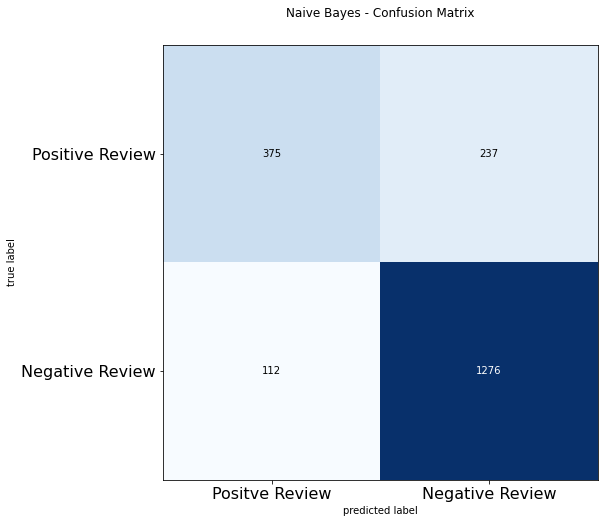

In [48]:
cm = confusion_matrix(y_test, pred_2)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Naive Bayes - Confusion Matrix")
plt.xticks(range(2), ["Positve Review","Negative Review"], fontsize=16)
plt.yticks(range(2), ["Positive Review","Negative Review"], fontsize=16)
plt.show()

In [49]:
svm=SVC()
svm.fit(x_train,y_train)
pred_3=svm.predict(cv.transform(x_test))
score_3=accuracy_score(y_test,pred_3)

<Figure size 432x288 with 0 Axes>

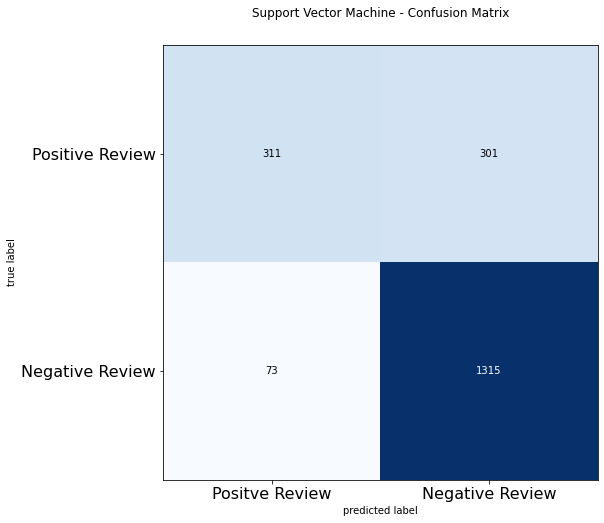

In [50]:
cm = confusion_matrix(y_test, pred_3)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Support Vector Machine - Confusion Matrix")
plt.xticks(range(2), ["Positve Review","Negative Review"], fontsize=16)
plt.yticks(range(2), ["Positive Review","Negative Review"], fontsize=16)
plt.show()